In [1]:
%run ../input/python-recipes/dhtml.py
dhtml('Data Type #3 => Multi-Labeled PNG Files')

In [2]:
%%writefile multilabel_data_h5.py
import h5py,os,pandas as pd,numpy as np
import seaborn as sn,pylab as pl
from IPython.display import display
from tensorflow.keras.preprocessing \
import image as tkimg

def images2array(files_path,img_size,preprocess):
    files_list=sorted(os.listdir(files_path))
    n,img_array=len(files_list),[]
    for i in range(n):
        if i%round(.1*n)==0:
            print('=>',end='',flush=True)
        img_path=files_path+files_list[i]
        if preprocess=='True':
            img=tkimg.load_img(img_path)
            img=tkimg.img_to_array(img)
            img=tkimg.smart_resize(
                img,(img_size,img_size))
        else:
            img=tkimg.load_img(
                img_path,target_size=(img_size,img_size))
            img=tkimg.img_to_array(img)
        img=np.expand_dims(img,axis=0)/255
        img_array.append(img)
    return np.array(np.vstack(img_array),
                    dtype='float32')

def labels2array(files_path,num_labels):
    files_list=sorted(os.listdir(files_path))
    labels1=[int(el[:2]) for el in files_list]
    label_set1=list(set(labels1))
    rd1=dict(zip(label_set1,
                 list(range(len(label_set1)))))
    labels1=np.array(
        [rd1.get(x,x) for x in labels1],
        dtype=np.int32)
    labels2=[int(el[3:5]) for el in files_list]
    label_set2=list(set(labels2))
    rd2=dict(zip(label_set2,
                 list(range(len(label_set2)))))
    labels2=np.array(
        [rd2.get(x,x) for x in labels2],
        dtype=np.int32)
    if num_labels==3:
        labels3=[int(el[6:8]) for el in files_list]
        label_set3=list(set(labels3))
        rd3=dict(zip(label_set3,
                     list(range(len(label_set3)))))
        labels3=np.array(
            [rd3.get(x,x) for x in labels3],
            dtype=np.int32)
        return [labels1,labels2,labels3]
    else:
        return [labels1,labels2]
    
def data2h5file(h5file,files_path,img_size,num_labels,
                names,preprocess='False'):
    images=images2array(files_path,img_size,preprocess)
    names1,names2=names[0],names[1]
    labels1=labels2array(files_path,num_labels)[0]
    maxlen1=max([len(n) for n in names1])
    names1=np.array([np.string_(name) 
                     for name in names1])
    labels2=labels2array(files_path,num_labels)[1]
    maxlen2=max([len(n) for n in names2])
    names2=np.array([np.string_(name) 
                     for name in names2])
    if num_labels==3:
        names3=names[2]
        labels3=labels2array(files_path,num_labels)[2]
        maxlen3=max([len(n) for n in names3])
        names3=np.array([np.string_(name) 
                         for name in names3])
    with h5py.File(h5file,'w') as f:
        f.create_dataset('images',data=images,
                         compression="gzip")
        f.create_dataset('labels1',data=labels1,
                         compression="gzip")
        f.create_dataset('names1',data=names1,
                         dtype='S%d'%maxlen1,
                         compression="gzip")
        f.create_dataset('labels2',data=labels2,
                         compression="gzip")
        f.create_dataset('names2',data=names2,
                         dtype='S%d'%maxlen2,
                         compression="gzip")
        if num_labels==3:
            f.create_dataset('labels3',data=labels3,
                             compression="gzip")
            f.create_dataset('names3',data=names3,
                             dtype='S%d'%maxlen3,
                             compression="gzip")
        f.close()
    print('\nfile size: %s'%list(os.stat(h5file))[6])
    
def h5file2data(h5file,num_labels,cmap='Pastel1'):
    with h5py.File(h5file,'r') as f:
        keys=list(f.keys())
        print('file keys: '+', '.join(keys))
        images=np.array(f[keys[0]])
        labels1=np.array(f[keys[1]])
        names1=[el.decode('utf-8') for el in f[keys[4]]]
        labels2=np.array(f[keys[2]])
        names2=[el.decode('utf-8') for el in f[keys[5]]]
        if num_labels==3:
            labels3=np.array(f[keys[3]])
            names3=[el.decode('utf-8') for el in f[keys[6]]]
        f.close()
    del h5file
    N=labels1.shape[0]; n=int(.1*N)
    shuffle_ids=np.arange(N)
    np.random.RandomState(12).shuffle(shuffle_ids)
    images=images[shuffle_ids]
    labels1=labels1[shuffle_ids]
    labels2=labels2[shuffle_ids]
    x_test,x_valid,x_train=\
    images[:n],images[n:2*n],images[2*n:]
    y_test1,y_valid1,y_train1=\
    labels1[:n],labels1[n:2*n],labels1[2*n:]
    y_test2,y_valid2,y_train2=\
    labels2[:n],labels2[n:2*n],labels2[2*n:]
    if num_labels==3:
        labels3=labels3[shuffle_ids]
        y_test3,y_valid3,y_train3=\
        labels3[:n],labels3[n:2*n],labels3[2*n:]
    print('data outputs: ')
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [x_train.dtype,x_valid.dtype,x_test.dtype],
                     [y_train1.shape,y_valid1.shape,y_test1.shape],
                     [y_train1.dtype,y_valid1.dtype,y_test1.dtype],
                     [y_train2.shape,y_valid2.shape,y_test2.shape],
                     [y_train2.dtype,y_valid2.dtype,y_test2.dtype]],
                    columns=['train','valid','test'],
                    index=['image shape','image type',
                           'label 1 shape','label 1 type',
                           'label 2 shape','label 2 type'])
    if num_labels==3:
        df.loc['label 3 shape']=\
        [y_train3.shape,y_valid3.shape,y_test3.shape]
        df.loc['label 3 type']=\
        [y_train3.dtype,y_valid3.dtype,y_test3.dtype]
    display(df)
    print('distribution of labels: ')
    df=pd.DataFrame([labels1,labels2],
                    index=['label 1','label 2']).T
    df['name 1']=[names1[l] for l in labels1]
    df['name 2']=[names2[l] for l in labels2]
    if num_labels==3:
        df['label 3']=labels3
        df['name 3']=[names3[l] for l in labels3]
    fig=pl.figure(figsize=(10,10))    
    for i in range(num_labels):
        ax=fig.add_subplot(num_labels,1,i+1)
        sn.countplot(x='name %s'%(i+1),data=df,
                     palette=cmap,alpha=.5,ax=ax)
    pl.show()       
    result=[x_train,x_valid,x_test,
            y_train1,y_valid1,y_test1,names1,
            y_train2,y_valid2,y_test2,names2]
    if num_labels==3:
        result+=[y_train3,y_valid3,y_test3,names3]
    return result

def display_images(images,labels,names,num_labels,n):
    labels1,labels2=labels[0],labels[1]
    names1,names2=names[0],names[1]
    if num_labels==3:
        labels3=labels[2]; names3=names[2]
    fig=pl.figure(figsize=(10,n))
    randch=np.random.choice(
        len(labels1),size=n,replace=False)
    for i,idx in enumerate(randch):
        ax=fig.add_subplot(
            n//3,3,i+1,xticks=[],yticks=[])
        ax.imshow(images[idx])
        label=[labels1[idx],labels2[idx]]
        name=[names1[labels1[idx]],
                names2[labels2[idx]]]
        if num_labels==3:
            label+=[labels3[idx]]
            name+=[names3[labels3[idx]]]
        ax.set_title('{} \n {}'\
                     .format(str(label),str(name)),
                     fontsize=10)
    pl.show()

Writing multilabel_data_h5.py


In [3]:
%run multilabel_data_h5.py

In [4]:
files_path1='../input/classification-of-handwritten-letters/'+\
            'zip_letters/letters/'
img_size1=32; num_labels1=3
h5file1='Letters'+str(img_size1)+'.h5'
names11=['lowercase','uppercase']
names12=[s.encode('utf-8') for s in 
         u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя']
names13=['single-colored paper','striped paper',
         'squared paper','graph paper']

In [5]:
data2h5file(h5file1,files_path1,img_size1,num_labels1,
            [names11,names12,names13],preprocess='True')

=>=>=>=>=>=>=>=>=>=>
file size: 46124128


file keys: images, labels1, labels2, labels3, names1, names2, names3
data outputs: 


,train,valid,test
image shape,"(11352, 32, 32, 3)","(1419, 32, 32, 3)","(1419, 32, 32, 3)"
image type,float32,float32,float32
label 1 shape,"(11352,)","(1419,)","(1419,)"
label 1 type,int32,int32,int32
label 2 shape,"(11352,)","(1419,)","(1419,)"
label 2 type,int32,int32,int32
label 3 shape,"(11352,)","(1419,)","(1419,)"
label 3 type,int32,int32,int32


distribution of labels: 


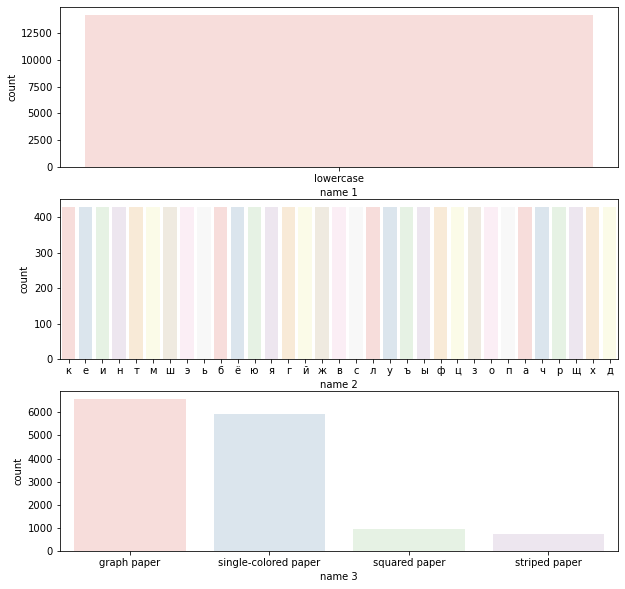

In [6]:
[x_train1,x_valid1,x_test1,
 y_train11,y_valid11,y_test11,names11,
 y_train12,y_valid12,y_test12,names12,
 y_train13,y_valid13,y_test13,names13]=\
h5file2data(h5file1,num_labels1)

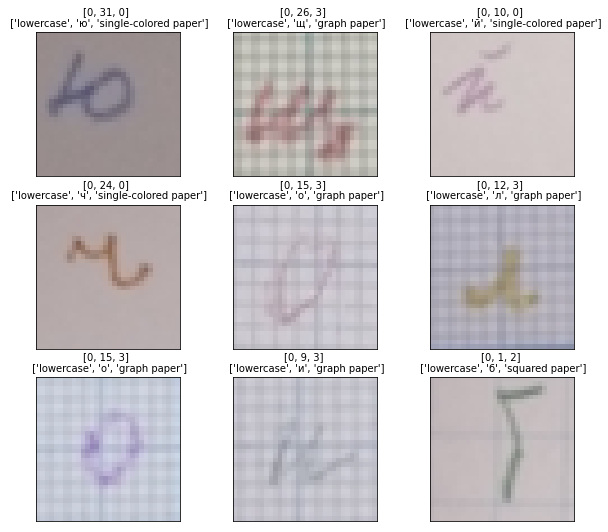

In [7]:
display_images(
    x_train1,[y_train11,y_train12,y_train13],
    [names11,names12,names13],num_labels1,9)

In [8]:
dhtml('In Progress')